<a href="https://colab.research.google.com/github/bhonsleaditya1/Lending-Club-PySpark/blob/master/Lending_Club_XGBoost_BayesianCV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q bayesian-optimization
!pip install -q scikit-optimize

     |████████████████████████████████| 81kB 2.1MB/s 


In [ ]:
import os,gc,re,matplotlib,joblib,ast
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection  import StratifiedKFold,train_test_split,cross_validate
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,StandardScaler,LabelEncoder,LabelBinarizer
from sklearn.metrics import roc_auc_score,auc,roc_curve,accuracy_score,classification_report,confusion_matrix,f1_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import xgboost as xgb
from scipy.stats import zscore
from sklearn import model_selection 
#from bayes_opt import BayesianOptimization
from sklearn.cluster import DBSCAN
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
pdf = pd.read_csv('/content/drive/My Drive/Lending-Club/loanFinal.csv', header=0, escapechar='\\')
dropcol = pd.read_csv('/content/drive/My Drive/Lending-Club/FinalDrop.csv',header=None)[0].to_list()
dbindex = pd.read_csv('/content/drive/My Drive/Lending-Club/DBRemove.csv')
pdf = pdf[pdf.amnt_left_per<=100]
#pdf = pdf[pdf.amnt_left_per>=0]
pdf = pdf.drop(dropcol,axis=1)
#pdf=pdf[pdf['application_type'].isin(['Joint App','Individual'])]
#pdf=pdf[pdf['initial_list_status'].isin(['w','f'])]
pdf = pdf.drop(dbindex['index'].to_list())
pdf = pdf.reset_index().drop('index',axis=1)
pdf.count()
pdf['year'] = pd.DatetimeIndex(pdf['issue_d']).year
#pdf = pdf.drop(dt,axis=1)
reg = pdf.select_dtypes(['float64']).columns
clas = pdf.select_dtypes(['O']).columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,49,117,118,119,122,123,124,127) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
pd.DataFrame(pdf.columns).to_excel('Variables Used.xlsx')

In [ ]:
sns.countplot(x='amnt_left_per',data=pdf[['target','amnt_left_per']],hue='target')

KeyboardInterrupt: ignored

In [ ]:
del train,X_train,X_test,timetest
gc.collect()

367

In [ ]:
pd.DataFrame(pdf.columns).to_excel('Variables.xlsx',index=None)

In [ ]:
#OneHotEncoding 0 vs R 
pdf.loc[pdf['target']==2,'target']=1
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['year'],axis=1)
train = train.drop(['year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
timetest = scale.transform(timetest)

In [ ]:
#OneHotEncoding 1 vs R 
pdf.loc[pdf['target']==2,'target']=0
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['year'],axis=1)
train = train.drop(['year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
timetest = scale.transform(timetest)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (41,49,117,118,119,122,123,124,127) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
#OneHotEncoding 2 vs R 
pdf.loc[pdf['target']==1,'target']=0
pdf.loc[pdf['target']==2,'target']=1
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['year'],axis=1)
train = train.drop(['year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)
scale = StandardScaler()
scale.fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)
timetest = scale.transform(timetest)

In [ ]:
X_train[np.isnan(X_train)]=-999
X_test[np.isnan(X_test)]=-999
timetest[np.isnan(timetest)]=-999

In [ ]:
#OneHotEncoding MultiClass 
#pdf.loc[pdf['target']==2,'target']=1
p = pd.DataFrame(index=None)
for i in clas:
  if pdf[i].nunique()<25:
    l = pd.get_dummies(pdf[i], prefix=i)
    for j in l.columns:
      pdf[j] = l[j]
for i in clas:
  pdf = pdf.drop(i,axis=1)
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['year'],axis=1)
train = train.drop(['year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

In [ ]:
pdf = pdf.rename(columns={'emp_length_< 1 year':'emp_length_less 1 year'})

In [ ]:
gc.collect()

707

In [ ]:
pdf['application_type'].unique()

array([ True, False])

In [ ]:
u ={}
for i in clas:
  u[i]=pdf[i].nunique()
print(u)

In [ ]:
#LabelEncoding
#pdf = pdf[pdf['target']!=1]
pdf.loc[pdf['target']==2,'target']=1
clas = pdf.select_dtypes(include=['O']).columns
lb_make = LabelEncoder()
for col in clas:
  pdf[col] = pdf[col].astype(str).fillna('')
  pdf[col]=lb_make.fit_transform(pdf[[col]])
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
timetest = timetest.drop(['issue_d','year'],axis=1)
train = train.drop(['issue_d','year'],axis=1)
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
#y_t=LabelBinarizer().fit_transform(y_t['target'].tolist())
#y_timetest=LabelBinarizer().fit_transform(y_timetest['target'].tolist())
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    #fpr, tpr, _ = roc_curve(y_true, y_pred)
    #roc_auc = auc(fpr, tpr)
    gini = calc_gini(y_true,y_pred,3)
    for i in gini:
      err += gini[i]
    err=err/2
    return 'gini_err', err

In [ ]:
y_train['target'].unique()

array([0, 1])

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
features

NameError: ignored

In [ ]:
y_pred = mlp.predict(X_test)
y_predtrain = mlp.predict(X_train)
y_predtime = mlp.predict(timetest)

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_train,y_predtrain))
print(classification_report(y_train,y_predtrain))
print(confusion_matrix(y_timetest,y_predtime))
print(classification_report(y_timetest,y_predtime))

[[238899   9888]
 [ 54708  10953]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88    248787
           1       0.53      0.17      0.25     65661

    accuracy                           0.79    314448
   macro avg       0.67      0.56      0.57    314448
weighted avg       0.75      0.79      0.75    314448

[[556865  22510]
 [127692  26645]]
              precision    recall  f1-score   support

           0       0.81      0.96      0.88    579375
           1       0.54      0.17      0.26    154337

    accuracy                           0.80    733712
   macro avg       0.68      0.57      0.57    733712
weighted avg       0.76      0.80      0.75    733712

[[182072  22740]
 [ 50549  22742]]
              precision    recall  f1-score   support

           0       0.78      0.89      0.83    204812
           1       0.50      0.31      0.38     73291

    accuracy                           0.74    278103
   macro avg       0.64

In [ ]:
'''def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    err = gini
    return 'gini_err', err
'''
def gini_eval(y_pred, dtrain):
  err=0
  y_true = dtrain.get_label()
  #fpr, tpr, _ = roc_curve(y_true, y_pred)
  #roc_auc = auc(fpr, tpr)
  #gini = 2*roc_auc -1
  gini = calc_gini(y_true,y_pred,3)
  for i in gini:
    err += gini[i]
  err=err/3
  #err = 1-gini
  gc.collect()
  return 'gini_err', err
dtrain = xgb.DMatrix(X_train,label=y_train)
result = {}
dtest = xgb.DMatrix(timetest,y_timetest)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
params = {
    'max_depth':8,
    'n_estimators':800,
    'reg_lambda':6,
    'objective':'multi:softprob',
    'tree_method':'gpu_hist',
    'scale_pos_weight':10,
    'num_class':3
}
classifier = xgb.train(params,num_boost_round=500,dtrain=dtrain,feval=gini_eval,evals=watchlist,early_stopping_rounds=30,evals_result=result)
#classifier= OneVsRestClassifier(model)
#,eval_metric='mlogloss' ,eval_set=eval_set,early_stopping_rounds=30)
#classifier.fit(X_train,y_train)

[0]	train-merror:0.207335	eval-merror:0.263366	train-gini_err:0.458829	eval-gini_err:0.385549
Multiple eval metrics have been passed: 'eval-gini_err' will be used for early stopping.

Will train until eval-gini_err hasn't improved in 30 rounds.
[1]	train-merror:0.207173	eval-merror:0.261867	train-gini_err:0.468475	eval-gini_err:0.396469
[2]	train-merror:0.206841	eval-merror:0.261486	train-gini_err:0.474394	eval-gini_err:0.400989
[3]	train-merror:0.20658	eval-merror:0.261108	train-gini_err:0.479062	eval-gini_err:0.404953
[4]	train-merror:0.206381	eval-merror:0.260871	train-gini_err:0.483071	eval-gini_err:0.407097
[5]	train-merror:0.206041	eval-merror:0.26058	train-gini_err:0.48645	eval-gini_err:0.408745
[6]	train-merror:0.205845	eval-merror:0.260461	train-gini_err:0.490242	eval-gini_err:0.410319
[7]	train-merror:0.205683	eval-merror:0.260529	train-gini_err:0.494128	eval-gini_err:0.410906
[8]	train-merror:0.205515	eval-merror:0.260497	train-gini_err:0.498385	eval-gini_err:0.411234
[9]	tr

In [ ]:
classifier.best_score

0.385549

In [ ]:
pd.DataFrame(classifier.get_score().items()).to_excel('Variables.xlsx',index=None)

In [ ]:
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    err = gini
    return 'gini_err', err

In [ ]:
fpr={}
tpr={}
gini={}
roc_auc={}
y_g = OneHotEncoder().fit_transform(pd.DataFrame(y_test)).toarray()
y_pred = classifier.predict_proba(X_test)
j=2
for i in range(j):
  fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_pred[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
  gini[i]=2*roc_auc[i]-1

In [ ]:
gini

{0: 0.9448136219690753, 1: 0.9448136217224645}

In [ ]:
res = classifier.predict_proba(X_test)
#calc_gini(res,y_test,2)
#t =float(1-np.sum(y_t==1)/len(y_t))

In [ ]:
1-np.sum(y_test==1)/len(y_test)

target    0.883875
dtype: float64

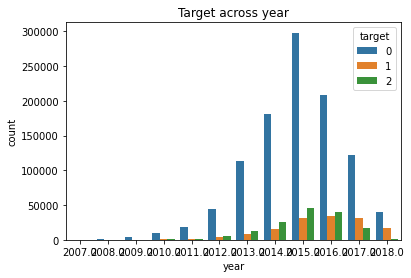

In [ ]:
plt.title('Target across year')
sns.countplot(x='year',hue='target',data=pdf[['year','target']])

In [ ]:
total = pdf['year'].groupby(pdf.year).count().sum()
pdf['year'].groupby(pdf.year).count()/total

year
2007.0    0.000187
2008.0    0.001161
2009.0    0.003485
2010.0    0.008557
2011.0    0.016173
2012.0    0.039885
2013.0    0.100752
2014.0    0.166018
2015.0    0.280946
2016.0    0.211130
2017.0    0.128413
2018.0    0.043292
Name: year, dtype: float64

In [ ]:
def dbscan(X, eps, min_samples):
  ss = MinMaxScaler()
  X = ss.fit_transform(X)
  X[np.isnan(X)]=-1
  db = DBSCAN(eps=eps, min_samples=min_samples,n_jobs=8)
  db.fit(X)
  y_pred = db.fit_predict(X)
  ##plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
  #plt.title("DBSCAN")
  return db.labels_,y_pred

In [ ]:
reg = pdf.select_dtypes(['float64']).columns
X = pdf[pdf.target==0]
X = X[reg]
ss = MinMaxScaler()
X = ss.fit_transform(X)

In [ ]:
X[np.isnan(X)]=-1
db = DBSCAN(eps=0.5, min_samples=5,n_jobs=8)
db.fit(X)

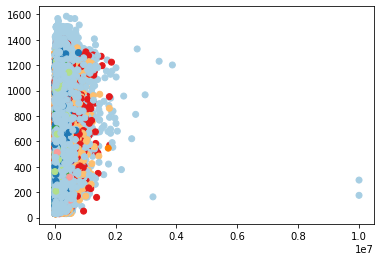

In [ ]:
plt.scatter(X['tot_hi_cred_lim'], X['installment'],c=y_pred, cmap='Paired')

In [ ]:
li = np.where(remove==-1)[0].tolist()
t = pdf[pdf.target==1].reset_index()
re = t.iloc[li]

In [ ]:
re['index'].to_excel('RemoveDBScan1.xlsx',index=False)

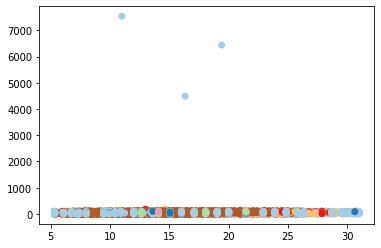

In [ ]:
plt.scatter(X['int_rate'], X['revol_util'],c=y_pred, cmap='Paired')

In [ ]:
#tar = pdf[pdf['target']==2]
#ss = StandardScaler()
#X = ss.fit_transform(tar)

db.fit(X)
#y_pred = db.fit_predict(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=10, n_jobs=8, p=None)

In [ ]:
y_pred = db.fit_predict(X)

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=1000)

In [ ]:
import numpy
numpy.set_printoptions(threshold=1000)

In [ ]:
X = pdf[pdf['target']==2]

In [ ]:
db = DBSCAN(eps=0.3, min_samples=5,n_jobs=8).fit(X)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)
clusters = db.fit_predict(X)

In [ ]:
gc.collect()

0

In [ ]:
from sklearn.preprocessing import LabelEncoder
data = pd.DataFrame(index=None)
clas = pdf.select_dtypes(include=['O']).columns
reg = pdf.select_dtypes(include=['float64','int64']).columns
#y = pdf['target']
#pdf = pdf[pdf['target']!=1]
#pdf.loc[pdf['target']==2,'target']=1

#for col in reg:
#  pdf[col] = pdf[col].fillna(999999999)
  #scaler = StandardScaler() 
  #pdf_scaled = scaler.fit_transform(pdf)
  #X[col] = X[col].fillna(X[col])
lb_make = OneHotEncoder()
for col in clas:
  pdf[col] = pdf[col].astype(str).fillna('')
  pdf[col]=lb_make.fit_transform(pdf[col])
for col in pdf.columns:
  if pdf[col].dtype == 'float64':
    m = pdf[col].mean()
  pdf['z'] = zscore(pdf[col])
  pdf.loc[pdf['z'].abs()>3,col] = m
pdf = pdf.drop('z',axis =1)
timetest = pdf[pdf.year==2016]
train = pdf[pdf.year!=2016]
y_timetest=pd.DataFrame()
y_t = pd.DataFrame()
y_timetest['target'] = timetest['target']
y_t['target'] = train['target']
timetest = timetest.drop('target',axis=1)
train = train.drop('target',axis=1)
del reg,clas
X_train, X_test, y_train, y_test = train_test_split(train, y_t, random_state=1301, test_size=0.3)

SyntaxError: ignored

In [ ]:
def gini_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc-1
    err = gini
    return 'gini_err', err
classifier = xgb.XGBClassifier(max_depth= 6,objective= 'multi:softprob',tree_method='gpu_hist',num_class=3)
classifier.fit(X_train,y_train,eval_metric=gini_eval,evals=[(timetest,y_timetest)])

TypeError: ignored

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The optimal number of features is 1
The selected features are:
['int_rate']


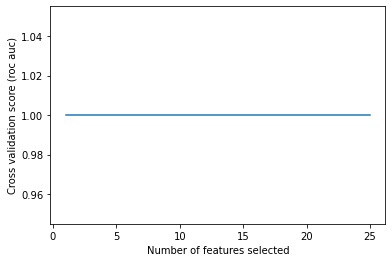

In [ ]:
#@title Default title text
matplotlib.use("Agg") #Needed to save figures

# classifier = RandomForestClassifier(random_state=1301)
# classifier = ExtraTreesClassifier(random_state=1301)
params = {
    'max_depth': 6,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 3,
    # Set number of GPUs if available   
    'n_gpus': 0
}
classifier = xgb.XGBClassifier(
    objective='binary:logistic', 
    n_estimators=200, 
    learning_rate=0.08, 
    max_depth=5,
    n_jobs=8, 
    subsample=0.9,
#    colsample_bytree=0.8,
    reg_lambda=6,
    reg_alpha=5,
    #num_class=3,
    silent=True,
    #n_gpus=1
)
#dtrain = xgb.DMatrix(X_train,label=y_train)
#dtest = xgb.DMatrix(X_test,label=y_test)

skf = StratifiedKFold(n_splits=3,random_state=1301, shuffle=True)


selector = RFECV(estimator=classifier, step=3,cv=skf.get_n_splits(y_t), scoring='roc_auc',n_jobs=8)
selector.fit(X_train, y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (roc auc)")
plt.plot(features, selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

In [ ]:
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """
    #return feature + str(df[feature].dtype)
    lst = []
    if (str(df[feature].dtype) == 'float64') or (str(df[feature].dtype) == 'int64'):
      #print(feature)
      #print(str(df[feature].dtype))
      df[feature] = df[feature].fillna(999999999)
      l = len(pd.qcut(df[feature],q=5,duplicates='drop').value_counts())
      df[feature] = pd.qcut(df[feature],labels=np.arange(l) ,q=5,duplicates='drop')
    else:
      if len(df[feature].unique())>=20:
        return -1,-1
      else:
        df[feature] = df[feature].fillna("")
    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] != 0)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

In [ ]:
i,v=calc_iv(pdf[['target','amnt_left_per']],feature='amnt_left_per',target='target')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
v

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,amnt_left_per,0,265229,0,265229,0.2,1.000000,0.0,0.904404,0.000000,-0.000000
1,amnt_left_per,1,1060916,1032881,28035,0.8,0.026425,1.0,0.095596,2.347619,2.123195


In [ ]:
pd.qcut(pdf['amnt_left_per'],q=10,duplicates='drop')

0           (65.275, 100.0]
1           (65.275, 100.0]
2           (65.275, 100.0]
3           (65.275, 100.0]
4           (65.275, 100.0]
                 ...       
1326140    (-0.001, 23.094]
1326141     (65.275, 100.0]
1326142     (65.275, 100.0]
1326143    (-0.001, 23.094]
1326144     (65.275, 100.0]
Name: amnt_left_per, Length: 1326145, dtype: category
Categories (3, interval[float64]): [(-0.001, 23.094] < (23.094, 65.275] < (65.275, 100.0]]

In [ ]:
len(pd.qcut(pdf['loan_amnt'],q=5,duplicates='drop').value_counts())

5

In [ ]:
columns = pdf.columns.to_list()
j=0
columns.remove('target')
iv={}
data = pd.DataFrame(index=None)
for col in tqdm(pdf.columns):
  #print(calc_iv(pdf[['target',col]],col,'target'))
  i,d = calc_iv(pdf[['target',col]],feature=col,target='target')
  iv[col] = i
  if i == -1:
    j +=1
    continue
  else:
    data =data.append(d)

  0%|          | 0/143 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
  2%|▏         | 3/143 [00:01<01:11,  1.96it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

AttributeError: ignored

In [ ]:
data[data.Variable=='debt_settlement_flag']

,Variable,Value,All,Good,Bad,Share,Bad Rate,Distribution Good,Distribution Bad,WoE,IV
0,debt_settlement_flag,,102,82,20,0.000077,0.196078,0.000079,0.000068,0.151948,0.000002
1,debt_settlement_flag,Cash,10,6,4,0.000008,0.400000,0.000006,0.000014,-0.853574,0.000007
2,debt_settlement_flag,N,1293482,1032882,260600,0.975283,0.201472,0.999911,0.888543,0.118083,0.013151
3,debt_settlement_flag,Y,32669,4,32665,0.024632,0.999878,0.000004,0.111375,-10.266804,1.143423


In [ ]:
for i in iv:
  if iv[i] >=1:
    print(i)

total_rec_prncp
last_pymnt_amnt
debt_settlement_flag
amnt_left_per


In [ ]:
features = ['term', 'grade', 'sub_grade', 'issue_d', 'total_rec_late_fee', 'last_pymnt_d', 'last_credit_pull_d', 'mort_acc', 'hardship_start_date']

In [ ]:
y_pred = classifier.predict(X_test)
y_predtime = classifier.predict(timetest)
print(accuracy_score(y_pred,y_test))
print(accuracy_score(y_timetest,y_predtime))

0.9362366556214188
0.8845631824951217


In [ ]:
def estimator(params ):
    # initialize model
    #model = SVC(C=C, gamma=gamma, degree=1, random_state=0)
    model = xgb.XGBClassifier(**params
                              n_jobs = 8,
                              objective = 'binary:logistic',
                              #eval_metric = 'auc',
                              #learning_rate = 0.08,
                              silent=1,
                              #early_stopping = 20,
                              #n_estimators = 1000,
                              tree_method='hist',
                              grow_policy='lossguide',
                              #num_class=3,
                              #early_stopping_rounds=30
                              )
    # set in cross-validation
    result = cross_validate(model, X_train, y_train, cv=5,scoring='auc',n_jobs=8)
    # result is mean of test_score
    return result

hparams = {
        'min_child_weight': (15, 20),
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-6, 500, 'log-uniform')
    }

# give model and hyperparameter to optmizer
svc_bayesopt = BayesianOptimization(estimator, hparams)

ValueError: ignored

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
bayes_cv_tuner = RandomizedSearchCV(estimator = xgb.XGBClassifier(
                                n_jobs = 8,
                                objective = 'binary:logistic',
                                #eval_metric = 'auc_ro',
                                learning_rate = 0.08,
                                silent=1,
                                #early_stopping = 20,
                                n_estimators = 1000,
                                tree_method='gpu_hist',
                                #grow_policy='lossguide',
                                #num_class=3,
                                #early_stopping_rounds=30
                                ),
    param_distributions = {
        'max_depth': (6, 8),
        'max_delta_step': (0, 20),
        'subsample': (0.01, 1.0, 'uniform'),
        'colsample_bytree': (0.01, 1.0, 'uniform'),
        'colsample_bylevel': (0.01, 1.0, 'uniform'),
        'reg_lambda': (1e-2, 1000, 'log-uniform'),
        'reg_alpha': (1e-2, 1.0, 'log-uniform'),
        'gamma': (1e-2, 0.5, 'log-uniform'),
        'min_child_weight': (0, 20),
        'scale_pos_weight': (1e-6, 500, 'log-uniform'),
        
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=42),
    n_jobs = 8,
    n_iter = 300,   
    verbose = 500,
    refit = True,
    random_state = 12345)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner.cv_results_)    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner.best_score_, 4),
        bayes_cv_tuner.best_params_
    )) 
    # Save all model results
    clf_name = bayes_cv_tuner.estimator.__class__.__name__
    all_models.to_csv(clf_name + "2_cv_results.csv")

result = bayes_cv_tuner.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done   6 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    5.2s
[Parallel(n_jobs=8)]: Done  11 tasks      | elapsed:    5.5s
[Parallel(n_jobs=8)]: Done  12 tasks      | elapsed:    5.6s
[Parallel(n_jobs=8)]: Done  13 tasks      | elapsed:    5.8s
[Parallel(n_jobs=8)]: Done  14 tasks      | elapsed:    6.7s
[Parall

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    7.7s
[Parallel(n_jobs=8)]: Done  17 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done  18 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done  19 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done  20 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done  21 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done  22 tasks      | elapsed:   11.2s
[Parallel(n_jobs=8)]: Done  23 tasks      | elapsed:   11.8s
[Parallel(n_jobs=8)]: Done  24 tasks      | elapsed:   12.9s
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=8)]: Done  26 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done  27 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  28 tasks      | elapsed:   13.8s
[Parallel(n_jobs=8)]: Done  29 tasks      | elapsed:   15.1s
[Parallel(n_jobs=8)]: Done  30 tasks      | elapsed:   15.3s
[Parallel(n_jobs=8)]: Done  31 tasks      | elapsed:   15.4s
[Parallel(n_jobs=8)]: Do

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1 
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini
def gini_eval(y_pred, dtrain):
    err=0
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc -1
    #gini = calc_gini(y_true,y_pred,2)
    #for i in gini:
    #  err += gini[i]
    #gini = (gini[0]+gini[1])/2
    #err = 1-gini
    err=1-gini
    gc.collect()
    return 'gini_err', err
clf = xgb.XGBClassifier(tree_method='gpu_hist',objective='binary:logistic',num_boost_round=70,verbose_eval=False,n_jobs=-1)
clf.fit(X_train,y_train['target'],eval_metric=gini_eval,eval_set=[(X_train,y_train['target']),(timetest,y_timetest['target'])],early_stopping_rounds=50)

[0]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.747254	validation_1-gini_err:0.82508
Multiple eval metrics have been passed: 'validation_1-gini_err' will be used for early stopping.

Will train until validation_1-gini_err hasn't improved in 50 rounds.
[1]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.72693	validation_1-gini_err:0.817239
[2]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.726937	validation_1-gini_err:0.803281
[3]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.724584	validation_1-gini_err:0.801163
[4]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.714649	validation_1-gini_err:0.767393
[5]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.71324	validation_1-gini_err:0.771955
[6]	validation_0-error:0.106313	validation_1-error:0.141951	validation_0-gini_err:0.71245	validation_1-g

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, num_boost_round=70, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbose_eval=False, verbosity=1)

In [ ]:
train.columns

Index(['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'revol_util', 'total_acc', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt',
       'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc',
       'mths_since_recent_bc_dlq', 'mths_since_recent_inq',
       'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_rev_accts',
       'num_sats', '

In [ ]:
X_train=pd.DataFrame(X_train)
X_train.columns = train.columns
X_test=pd.DataFrame(X_test)
X_test.columns = train.columns
timetest=pd.DataFrame(timetest)
timetest.columns = train.columns

In [ ]:
pd.DataFrame.from_dict(result.cv_results_).to_excel('Random_searchcv_0vr.xlsx')

In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(timetest,label=y_timetest)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
cvvalues = []
evalsdict={}
ginivalues=[]
#Bayesian Optimization function for xgboost
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1 
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini
def gini_eval(y_pred, dtrain):
    err=0
    y_true = dtrain.get_label()
    #fpr, tpr, _ = roc_curve(y_true, y_pred)
    #roc_auc = auc(fpr, tpr)
    #gini = 2*roc_auc -1
    gini = calc_gini(y_true,y_pred,3)
    #for i in gini:
    #  err += gini[i]
    gini = (gini[0]+gini[1]+gini[2])/3
    #err = 1-gini
    err=1-gini
    gc.collect()
    return 'gini_err', err
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth,gamma,n_estimators,learning_rate,reg_alpha,scale_pos_weight,colsamplebytree,max_delta_step):
  global cvvalues,ginivalues,X_train,y_train,timetest,y_timetest
  dicct={}
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'reg_alpha':reg_alpha,
          'scale_pos_weight':scale_pos_weight,
          'colsamplebytree':colsamplebytree,
          'eval_metric': 'mlogloss',
          'objective': 'multi:softmax',
          'num_class':3,
          'max_delta_step':max_delta_step,
          'tree_method':'gpu_hist'
          }
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  #cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5,
                     #feval=gini_eval
                     #metrics='logloss')
  clf = xgb.XGBClassifier(**params,n_jobs=-1)
  clf.fit(X_train,y_train['target'],eval_metric=gini_eval,eval_set=[(X_train,y_train['target']),(X_test,y_test['target'])],early_stopping_rounds=50,verbose=False)
  #Return the negative RMSE
  cvvalues.append(clf.best_score)
  return 1-clf.best_score

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'scale_pos_weight': (7,100),                                          
                                            'n_estimators':(100,1000),
                                            'reg_alpha': (0,1),
                                            'learning_rate': (0.01,0.5),
                                            'colsamplebytree':(0,1),
                                            'max_delta_step':(0,1)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | n_esti... | reg_alpha | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4172   |  0.8588   |  0.6693   |  0.3802   |  0.8557   |  7.537    |  788.5    |  0.1901   |  70.48    |
|  2        |  0.4263   |  0.967    |  0.8781   |  0.07036  |  0.2546   |  7.258    |  549.7    |  0.5445   |  75.52    |
|  3        |  0.4165   |  0.7943   |  0.5541   |  0.2449   |  0.7713   |  9.021    |  667.5    |  0.4216   |  25.59    |
|  4        |  0.425    |  0.008256 |  0.2509   |  0.4014   |  0.05933  |  4.209    |  606.8    |  0.4545   |  84.06    |
|  5        |  0.4134   |  0.5633   |  0.05934  |  0.4362   |  0.8242   |  8.03     |  890.5    |  0.2216   |  25.76    |
|  6        |  0.4249   |  0.9399   |  0.8539   |  0.4665   |  0.4541   |  3.406    |  102.2    |  0.4195   |  98.74    |
|  7        |  0.4263   

In [ ]:
xgb_bo.

In [ ]:
xgb_bo.maximize(n_iter=10, init_points=10, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | n_esti... | reg_alpha | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  11       |  0.217    |  0.4405   |  0.847    |  0.1086   |  0.4133   |  7.65     |  280.2    |  0.4705   |  47.3     |
|  12       |  0.2735   |  0.9922   |  0.3342   |  0.339    |  0.5452   |  3.738    |  334.9    |  0.02842  |  63.71    |
|  13       |  0.2164   |  0.6418   |  0.2815   |  0.3783   |  0.3861   |  3.642    |  868.2    |  0.3698   |  22.31    |
|  14       |  0.1536   |  0.09859  |  0.5056   |  0.4489   |  0.338    |  6.37     |  944.6    |  0.3231   |  77.41    |
|  15       |  0.3572   |  0.608    |  0.1599   |  0.2484   |  0.9748   |  9.238    |  112.5    |  0.01756  |  45.65    |
|  16       |  0.3346   |  0.3208   |  0.09083  |  0.149    |  0.7722   |  9.146    |  768.4    |  0.0702   |  46.14    |
|  17       |  0.313    

In [ ]:
xgb_bo.maximize(n_iter=10, init_points=10, acq='ei')

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | n_esti... | reg_alpha | scale_... |
-------------------------------------------------------------------------------------------------------------------------
|  21       |  0.2352   |  0.9391   |  0.695    |  0.1522   |  0.4634   |  6.68     |  257.1    |  0.1956   |  45.58    |
|  22       |  0.3595   |  0.2721   |  0.1479   |  0.4875   |  0.8763   |  5.526    |  751.1    |  0.3218   |  25.3     |
|  23       |  0.3154   |  0.6039   |  0.8097   |  0.2799   |  0.958    |  3.563    |  443.8    |  0.2497   |  9.031    |
|  24       |  0.3293   |  0.2231   |  0.8255   |  0.03041  |  0.6918   |  9.38     |  324.2    |  0.5555   |  47.77    |
|  25       |  0.3241   |  0.8411   |  0.914    |  0.1367   |  0.6522   |  4.484    |  927.5    |  0.2342   |  17.1     |
|  26       |  0.3472   |  1.0      |  1.0      |  0.01     |  1.0      |  10.0     |  1e+03    |  1.0      |  7.0      |
|  27       |  0.3472   

In [ ]:
pd.DataFrame.from_dict(xgb_bo.res).to_excel('/content/drive/My Drive/Lending-Club/multi_xg_val_params.xlsx',index=False)

In [ ]:
p = 

In [ ]:
y_t1 = OneHotEncoder().fit_transform(y_train).toarray()

In [ ]:
gc.collect()

22240

In [ ]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(timetest,label=y_timetest)
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
cvvalues = []
evalsdict={}
ginivalues=[]
#Bayesian Optimization function for xgboost
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1 
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini
def gini_eval(y_pred, dtrain):
    err=0
    y_true = dtrain.get_label()
    #fpr, tpr, _ = roc_curve(y_true, y_pred)
    #roc_auc = auc(fpr, tpr)
    #gini = 2*roc_auc -1
    gini = calc_gini(y_true,y_pred,3)
    #for i in gini:
    #  err += gini[i]
    gini = (gini[0]+gini[1]+gini[2])/3
    #err = 1-gini
    err=1-gini
    gc.collect()
    return 'gini_err', err
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth,gamma,n_estimators,learning_rate,reg_alpha,scale_pos_weight,colsamplebytree,max_delta_step):
  global cvvalues,ginivalues,X_train,y_train,timetest,y_timetest
  dicct={}
  params = {'max_depth': int(max_depth),
          'gamma': gamma,
          'n_estimators': int(n_estimators),
          'learning_rate':learning_rate,
          'subsample': 0.8,
          'eta': 0.1,
          'reg_alpha':reg_alpha,
          'scale_pos_weight':scale_pos_weight,
          'colsamplebytree':colsamplebytree,
          'eval_metric': 'mlogloss',
          'objective': 'multi:softmax',
          'num_class':3,
          'max_delta_step':max_delta_step,
          'tree_method':'gpu_hist'
          }
  #Cross validating with the specified parameters in 5 folds and 70 iterations
  #cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5,
                     #feval=gini_eval
                     #metrics='logloss')
  clf = xgb.XGBClassifier(**params,n_jobs=-1)
  clf.fit(X_train,y_train['target'],eval_metric=gini_eval,eval_set=[(X_train,y_train['target']),(X_test,y_test['target'])],early_stopping_rounds=50,verbose=False)
  #Return the negative RMSE
  cvvalues.append(clf.best_score)
  return 1-clf.best_score

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'scale_pos_weight': (7,100),                                          
                                            'n_estimators':(100,1000),
                                            'reg_alpha': (0,1),
                                            'learning_rate': (0.01,0.5),
                                            'colsamplebytree':(0,1),
                                            'max_delta_step':(0,1)
                                            })

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

ModuleNotFoundError: ignored

In [ ]:
#Bayesian
xgb_bo.max

{'params': {'colsamplebytree': 0.2816772147539488,
  'gamma': 0.43694469816425074,
  'learning_rate': 0.037051441268804004,
  'max_delta_step': 0.06083889327989889,
  'max_depth': 7.798122506709826,
  'n_estimators': 905.847934638579,
  'reg_alpha': 0.48401062914787196,
  'scale_pos_weight': 63.27431559332183},
 'target': 0.943879}

In [ ]:
def gini_eval(y_pred, dtrain):
    err=0
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc -1
    #gini = calc_gini(y_true,y_pred,2)
    #for i in gini:
    #  err += gini[i]
    #gini = (gini[0]+gini[1])/2
            #+gini[2])/3
    #err = 1-gini
    err=1-gini
    gc.collect()
    return 'gini_err', err
#p = pd.DataFrame.from_dict(xgb_bo.res)
para= xgb_bo.max['params']
para['n_estimators']=int(para['n_estimators'])
para['max_depth']=int(para['max_depth'])
para['scale_pos_weight']=int(para['scale_pos_weight'])
para['objective'] = 'binary:logistic'
#para['num_class'] = 3
para['tree_method'] ='gpu_hist'
clf = xgb.XGBClassifier(**para,n_jobs=-1)
clf.fit(X_train,y_train['target'],eval_metric=gini_eval,eval_set=[(X_train,y_train['target']),(X_test,y_test['target'])],early_stopping_rounds=50,verbose=False)
#res = clf.predict(X_test)
joblib.dump(clf, '/content/drive/My Drive/Lending-Club/Models/XGB_2_RFE.pkl')

['/content/drive/My Drive/Lending-Club/Models/XGB_2_RFE.pkl']

In [ ]:
 0.967    |  0.8781   |  0.07036  |  0.2546   |  7.258    |  549.7    |  0.5445   |  75.52   

In [ ]:
def gini_eval(y_pred, dtrain):
    err=0
    y_true = dtrain.get_label()
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    gini = 2*roc_auc -1
    #gini = calc_gini(y_true,y_pred,2)
    #for i in gini:
    #  err += gini[i]
    #gini = (gini[0]+gini[1])/2
            #+gini[2])/3
    #err = 1-gini
    err=1-gini
    gc.collect()
    return 'gini_err', err
params={'colsamplebytree': 0.0, 'gamma': 0.2602235751840525, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.40201543142021834, 'scale_pos_weight': 7, 'objective': 'binary:logistic', 'tree_method': 'gpu_hist'}
clf = xgb.XGBClassifier(**params,n_jobs=-1)
clf.fit(X_train[features],y_train['target'],eval_metric=gini_eval,eval_set=[(X_train[features],y_train['target']),(X_test[features],y_test['target'])],early_stopping_rounds=50,verbose=True)
joblib.dump(clf, '/content/drive/My Drive/Lending-Club/Models/XGB_2_RFE.pkl')

[0]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.748228	validation_1-gini_err:0.75701
Multiple eval metrics have been passed: 'validation_1-gini_err' will be used for early stopping.

Will train until validation_1-gini_err hasn't improved in 50 rounds.
[1]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.748228	validation_1-gini_err:0.75701
[2]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.748228	validation_1-gini_err:0.75701
[3]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.747344	validation_1-gini_err:0.756173
[4]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.747344	validation_1-gini_err:0.756173
[5]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.747344	validation_1-gini_err:0.756173
[6]	validation_0-error:0.399357	validation_1-error:0.400995	validation_0-gini_err:0.746912	validation_1-

['/content/drive/My Drive/Lending-Club/Models/XGB_2_RFE.pkl']

In [ ]:
#rfecv
xgb_bo.max

{'params': {'colsamplebytree': 1.0,
  'gamma': 1.0,
  'learning_rate': 0.01,
  'max_delta_step': 0.0,
  'max_depth': 10.0,
  'n_estimators': 100.0,
  'reg_alpha': 1.0,
  'scale_pos_weight': 100.0},
 'target': 0.366324}

In [ ]:
model =joblib.load('/content/drive/My Drive/Lending-Club/Models/XGB_2_RFE.pkl')
#features=['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bc_limit', 'term_36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'emp_length_10+ years', 'emp_length_less 1 year', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']

In [ ]:
X_train=pd.DataFrame(X_train)
X_train.columns = train.columns
X_test=pd.DataFrame(X_test)
X_test.columns = train.columns
timetest=pd.DataFrame(timetest)
timetest.columns = train.columns

In [ ]:
print(accuracy_score(y_train,model.predict(X_train)))
print(accuracy_score(y_test,model.predict(X_test)))
print(accuracy_score(y_timetest,model.predict(timetest)))

ValueError: ignored

In [ ]:
print(accuracy_score(y_train,model.predict(X_train[features])))
print(accuracy_score(y_test,model.predict(X_test[features])))
print(accuracy_score(y_timetest,model.predict(timetest[features])))

0.6645291340471465
0.6621762580776471
0.7487333829552361


In [ ]:
res

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import f1_score
res = clf.predict_proba(X_train)
th1=1-(y_train.target==0).sum()/y_train.target.count()*1
th2=1-(y_train.target==1).sum()/y_train.target.count()*1
c1=pd.DataFrame(res[:,0])
c2=pd.DataFrame(res[:,1])
print(f1_score(np.where(c1>c1.quantile(th1),1,0),np.where(y_train==0,1,0)))
print(f1_score(np.where(c2>c2.quantile(th2),1,0),np.where(y_train==1,1,0)))
res = clf.predict_proba(X_test)
th1=1-(y_test.target==0).sum()/y_test.target.count()*1
th2=1-(y_test.target==1).sum()/y_test.target.count()*1
c1=pd.DataFrame(res[:,0])
c2=pd.DataFrame(res[:,1])
print(f1_score(np.where(c1>c1.quantile(th1),1,0),np.where(y_test==0,1,0)))
print(f1_score(np.where(c2>c2.quantile(th2),1,0),np.where(y_test==1,1,0)))
res = clf.predict_proba(timetest)
th1=1-(y_timetest.target==0).sum()/y_timetest.target.count()*1
th2=1-(y_timetest.target==1).sum()/y_timetest.target.count()*1
c1=pd.DataFrame(res[:,0])
c2=pd.DataFrame(res[:,1])
print(f1_score(np.where(c1>c1.quantile(th1),1,0),np.where(y_timetest==0,1,0)))
print(f1_score(np.where(c2>c2.quantile(th2),1,0),np.where(y_timetest==1,1,0)))

0.9070699152671616
0.21882491699037215
0.9070029544880843
0.2116874114704198
0.8778926018120405
0.26189933378929503


In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
gini =0
j=3
y_predtrain=clf.predict_proba(X_train)
y_pred=clf.predict_proba(X_test)
y_predtime=clf.predict_proba(timetest)
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_test))
y_gini = drop_enc.transform(pd.DataFrame(y_test)).toarray()
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_timetest))
y_ginitime = drop_enc.transform(pd.DataFrame(y_timetest)).toarray()
drop_enc = OneHotEncoder().fit(pd.DataFrame(y_train))
y_ginitrain = drop_enc.transform(pd.DataFrame(y_train)).toarray()
for i in range(j):
    fpr[i], tpr[i], _ = roc_curve(y_ginitrain[:, i], y_predtrain[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)
for i in range(j):
    fpr[i], tpr[i], _ = roc_curve(y_gini[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)
for i in range(j):
    fpr[i], tpr[i], _ = roc_curve(y_ginitime[:, i], y_predtime[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(2*roc_auc[i]-1)

0.6003886554249318
0.6003886519308415
0.547319085418204
0.5473190860235022
0.6031981524538375
0.6031981497436099


In [ ]:
#Multi Class
res = clf.predict_proba(X_train)
c1=pd.DataFrame(res[:,1])
c2=pd.DataFrame(res[:,2])
print(f1_score(np.where(c1>c1.quantile(0.85),1,0),np.where(y_train==1,1,0)))
print(f1_score(np.where(c2>c2.quantile(0.85),1,0),np.where(y_train==2,1,0)))
res = clf.predict_proba(X_test)
c1=pd.DataFrame(res[:,1])
c2=pd.DataFrame(res[:,2])
print(f1_score(np.where(c1>c1.quantile(0.85),1,0),np.where(y_test==1,1,0)))
print(f1_score(np.where(c2>c2.quantile(0.85),1,0),np.where(y_test==2,1,0)))
res = clf.predict_proba(timetest)
c1=pd.DataFrame(res[:,1])
c2=pd.DataFrame(res[:,2])
print(f1_score(np.where(c1>c1.quantile(0.85),1,0),np.where(y_timetest==1,1,0)))
print(f1_score(np.where(c2>c2.quantile(0.85),1,0),np.where(y_timetest==2,1,0)))

IndexError: ignored

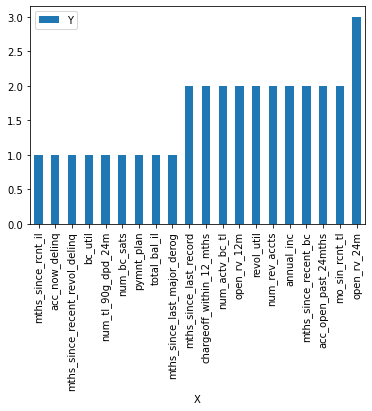

In [ ]:
import matplotlib.pyplot as plt
fscores = pd.DataFrame({'X': list(clf.get_fscore().keys()), 'Y': list(clf.get_fscore().values())})
fscores.sort_values(by='Y')[:20].plot.bar(x='X')

In [ ]:
p['params'][0]

{'colsamplebytree': 0.7437294745211924,
 'gamma': 0.6890874490069687,
 'learning_rate': 0.4398580735116945,
 'max_delta_step': 0.16470318541093687,
 'max_depth': 8.364398313729607,
 'n_estimators': 609.5899910058658,
 'reg_alpha': 0.01756406993503956,
 'scale_pos_weight': 8.241068307862609}

In [ ]:
gini={}
gini_train={}
gini_time={}
f1={}
f1_train={}
f1_time={}
for i in tqdm(range(10)):
  #para= ast.literal_eval(re.search('({.+})', p['params'][i]).group(0))
  para = p['params'][i]
  para['n_estimators']=int(para['n_estimators'])
  para['max_depth']=int(para['max_depth'])
  para['scale_pos_weight']=int(para['scale_pos_weight'])
  para['objective'] = 'reg:logistic'
  #para['num_class'] = 2
  dtrain = xgb.DMatrix(X_train,label=y_train)
  clf = xgb.train(para,dtrain)
  res = clf.predict(xgb.DMatrix(X_test))
  f1[i]=f1_score(y_test,res,average=None)
  gini[i]=calc_gini(y_test,res)
  res = clf.predict(xgb.DMatrix(X_train))
  f1_train[i]=f1_score(y_train,res,average=None)
  gini_train[i]=calc_gini(y_train,res)
  res = clf.predict(xgb.DMatrix(timetest))
  f1_time[i]=f1_score(y_timetest,res,average=None)
  gini_time[i]=calc_gini(y_timetest,res)

#result = clf.predict_proba(X_test)


  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
res = clf.predict(X_test)


In [ ]:
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1 
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  gc.collect()
  return gini

In [ ]:
para=xgb.max['params']
para['n_estimators']=int(para['n_estimators'])
para['max_depth']=int(para['max_depth'])
para['scale_pos_weight']=int(para['scale_pos_weight'])
para['objective'] = 'multi:softprob'
para['tree_method'] = 'gpu_hist'
para['num_class'] = 3

In [ ]:
gini={}
gini_train={}
gini_time={}
f1={}
f1_train={}
f1_time={}
p = pd.DataFrame.from_dict(xgb_bo.res)
for i in range(10):
  para=p['params'][i]
  para['n_estimators']=int(para['n_estimators'])
  para['max_depth']=int(para['max_depth'])
  para['scale_pos_weight']=int(para['scale_pos_weight'])
  para['objective'] = 'multi:softprob'
  para['tree_method'] = 'gpu_hist'
  para['num_class'] = 3
  #dtrain = xgb.DMatrix(X_train,label=y_train)
  clf = xgb.XGBClassifier(**para).fit(X_train,y_train)
  res = clf.predict_proba(X_test)
  gini[i]=calc_gini(y_test,res,3)
  res = clf.predict(X_test)
  f1[i]=f1_score(y_test,res,average=None)
  res = clf.predict_proba(X_train)
  gini_train[i]=calc_gini(y_train,res,3)
  res = clf.predict(X_train)
  f1_train[i]=f1_score(y_train,res,average=None)
  res = clf.predict_proba(timetest)
  gini_time[i]=calc_gini(y_timetest,res,3)
  res = clf.predict(timetest)
  f1_time[i]=f1_score(y_timetest,res,average=None)
  gc.collect()
  #fscores = pd.DataFrame({'X': list(clf.get_fscore().keys()), 'Y': list(clf.get_fscore().values())})
  #plt.figure(i)
  #fscores.sort_values(by='Y')[:20].plot.bar(x='X')
#result = clf.predict_proba(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

In [ ]:
test = pd.DataFrame.from_dict(gini)
train = pd.DataFrame.from_dict(gini_train)
time = pd.DataFrame.from_dict(gini_time)

In [ ]:
pd.DataFrame.from_dict(f1_time)

,0,1,2,3,4,5,6,7,8,9
0,0.849514,0.849394,0.849765,0.849069,0.845614,0.848876,0.848576,0.842479,0.849272,0.849280
1,0.296216,0.301085,0.280934,0.294255,0.296391,0.278993,0.301944,0.290719,0.175070,0.293637
2,0.000101,0.006971,0.000000,0.006917,0.031292,0.000000,0.014940,0.038437,0.000000,0.000000


In [ ]:
pd.set_option('display.max_colwidth', 100)
#p.T

In [ ]:
def calc_gini(y,y_p,j=1):
  gini ={}
  fpr={}
  tpr={}
  roc_auc={}
  g=0
  if j==1:
    fpr, tpr, _ = roc_curve(y, y_p)
    roc_auc = auc(fpr, tpr)
    gini=2*roc_auc-1
  else:
    y_g = OneHotEncoder().fit_transform(pd.DataFrame(y)).toarray()
    for i in range(j):
      fpr[i], tpr[i], _ = roc_curve(y_g[:, i], y_p[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
      gini[i]=2*roc_auc[i]-1   
  return gini

In [ ]:
def calc_f1(y,y_p)
 return f1_score(y, y_p, average='weighted')

In [ ]:
p = pd.DataFrame(index=None)
for i in cvvalues:
  p=p.append(i)
p.to_excel('/content/drive/My Drive/Lending-Club/01_ginieval.xlsx')
pd.DataFrame(xgb_bo.res).to_excel('/content/drive/My Drive/Lending-Club/01_ginieval_params.xlsx')

In [ ]:
params = xgb_bo.max['params']
print(params)
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['scale_pos_weight'] = int(params['scale_pos_weight'])
dtrain = xgb.DMatrix(X_train,label=y_train)
classifier = xgb.XGBClassifier(**params,n_jobs=8).fit(X_train,y_train)
#classifier = xgb.train(params=params,dtrain=dtrain)
#predicting for training set
#train_p = classifier.predict(X_test)

#Looking at the classification report


{'colsamplebytree': 0.9237794774103967, 'gamma': 0.29426934471501065, 'learning_rate': 0.3451676293927219, 'max_depth': 6.653738829160071, 'n_estimators': 644.9716762441991, 'reg_alpha': 0.10899022196561392, 'scale_pos_weight': 8.07302532737576}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
classifier.predict

In [ ]:
y_pred=clf.predict(X_test_s)
y_predtime=clf.predict(timetest[features])
#print(accuracy_score(y_test,y_pred))
#print(accuracy_score(y_timetest,y_predtime))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The optimal number of features is 54
The selected features are:
['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bc_limit', 'term_36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'emp_length_10+ years', 'emp_length_less 1 year', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Not Verified', 'verifi

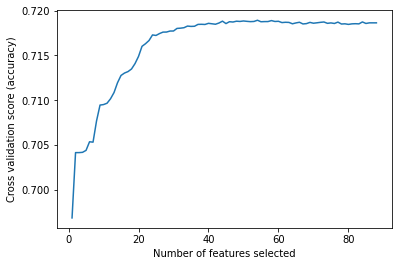

In [ ]:
classifier = xgb.XGBClassifier(max_depth= 8,objective= 'multi:softmax',num_class=3,tree_method='gpu_hist')

selector = RFECV(estimator=classifier,cv=StratifiedKFold(n_splits=5,random_state=1301, shuffle=True), scoring='f1_weighted')
selector.fit(X_train.fillna(-999999), y_train)

print('The optimal number of features is {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('The selected features are:')
print ('{}'.format(features))

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.savefig('feature_auc_nselected.png', bbox_inches='tight', pad_inches=1)

In [ ]:
features=['int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_record', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_tl_120dpd_2m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bc_limit', 'term_36 months', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'emp_length_10+ years', 'emp_length_less 1 year', 'home_ownership_MORTGAGE', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified']

In [ ]:
param = {'colsamplebytree': 0.0, 'gamma': 0.08514219913028119, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 3, 'n_estimators': 1000, 'reg_alpha': 0.0, 'scale_pos_weight': 100}

In [ ]:
clasr =xgb.XGBClassifier(**param,tree_method='gpu_hist',objective='multi:softmax',num_class=3)
clasr.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsamplebytree=0.0,
              gamma=0.08514219913028119, learning_rate=0.01, max_delta_step=1.0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
              n_jobs=1, nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=100,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
clasr.feature_importances_

array([0.07705729, 0.0064792 , 0.00863987, 0.01445381, 0.00517122,
       0.00289358, 0.00310317, 0.00273019, 0.00440048, 0.00296505,
       0.        , 0.00303413, 0.        , 0.00281576, 0.0021554 ,
       0.00448406, 0.0907246 , 0.02597603, 0.00939485, 0.02496363,
       0.        , 0.17902039, 0.02343108, 0.06436882, 0.02231523,
       0.00479326, 0.00461672, 0.02805343, 0.01409985, 0.0216965 ,
       0.00973591, 0.00404367, 0.        , 0.        , 0.00330976,
       0.00645505, 0.        , 0.00388331, 0.02244513, 0.0052769 ,
       0.00220095, 0.01052031, 0.00089285, 0.        , 0.00427754,
       0.00962603, 0.        , 0.00223149, 0.0030223 , 0.00795607,
       0.        , 0.        , 0.0027915 , 0.0019085 , 0.        ,
       0.00234442, 0.01133961, 0.00098368, 0.01103996, 0.06276905,
       0.        , 0.04279299, 0.01257367, 0.03686898, 0.00350252,
       0.00298335, 0.        , 0.00119891, 0.        , 0.00634972,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
pd.DataFrame(dict(zip(X_train,clasr.feature_importances_)).items()).to_excel('Bayesian_Multi_feature_imp.xlsx')

Out of sample auc: 0.9210090313665494


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0]	validation_0-auc:0.804924	validation_1-auc:0.806005
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.833126	validation_1-auc:0.83504
[2]	validation_0-auc:0.832749	validation_1-auc:0.833967
[3]	validation_0-auc:0.829036	validation_1-auc:0.8297
[4]	validation_0-auc:0.822992	validation_1-auc:0.823535
[5]	validation_0-auc:0.819661	validation_1-auc:0.82012
[6]	validation_0-auc:0.821091	validation_1-auc:0.821356
[7]	validation_0-auc:0.820592	validation_1-auc:0.820594
[8]	validation_0-auc:0.818315	validation_1-auc:0.818195
[9]	validation_0-auc:0.815123	validation_1-auc:0.814803
[10]	validation_0-auc:0.820379	validation_1-auc:0.81961
[11]	validation_0-auc:0.819681	validation_1-auc:0.819044
[12]	validation_0-auc:0.818099	validation_1-auc:0.817506
[13]	validation_0-auc:0.817013	validation_1-auc:0.816403
[14]	validation_0-auc:0.813709	validation_1-auc:0.813019
[15

ValueError: ignored

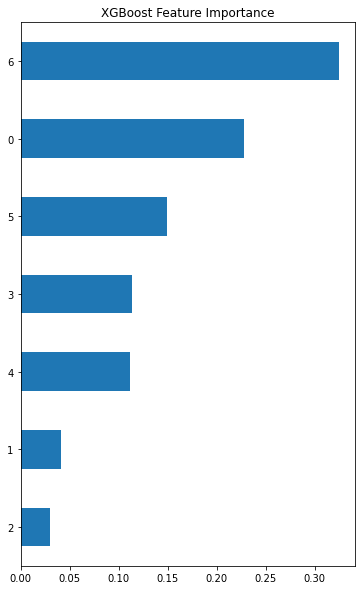

In [ ]:
X_train_s = X_train[features]

classifier.fit(X_train_s, y_train['target'])
test = pd.DataFrame()

X_test_s = X_test[features]
print ('Out of sample auc: {}'.format(classifier.score(X_test_s, y_test['target'])))

X_sel = X_train[features]

ratio = float(np.sum(y_t['target'] == 1)) / np.sum(y_t['target']==0)
clf = xgb.XGBClassifier(
                max_depth = 7,
                n_estimators=1000,
                learning_rate=0.1, 
                nthread=4,
                subsample=1.0,
                colsample_bytree=0.5,
                min_child_weight = 3,
                scale_pos_weight = ratio,
                seed=1301,
                n_jobs=8)
                
clf.fit(X_train_s, np.array(y_train), early_stopping_rounds=50, eval_metric="auc",eval_set=[(X_train_s, np.array(y_train)), (X_test_s, np.array(y_test))])
        
print('Overall AUC:', roc_auc_score(y_t, clf.predict_proba(train[features], ntree_limit=clf.best_iteration)[:,1]))


test['n0'] = (test == 0).sum(axis=1)
sel_test = timetest[features]
y_predtime = clf.predict_proba(sel_test, ntree_limit=clf.best_iteration)
#y_predtime = clf.predict_proba(sel_test, ntree_limit=clf.best_iteration)
y_pred = clf.predict_proba(X_test_s, ntree_limit=clf.best_iteration)
submission = pd.DataFrame({"ID":timetest.index, "TARGET":y_predtime[:,1]})
submission.to_csv("submission.csv", index=False)

mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(clf.feature_importances_)
ts.sort_values()[-15:].plot(kind="barh", title=("features importance"))
plt.clf()

featp = ts.sort_values()[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
y_predtime = clf.predict(sel_test, ntree_limit=clf.best_iteration)
y_pred = clf.predict(X_test_s, ntree_limit=clf.best_iteration)
print(accuracy_score(y_test,y_pred))
print(accuracy_score(y_timetest,y_predtime))

0.9088191541113516
0.8544494599387393


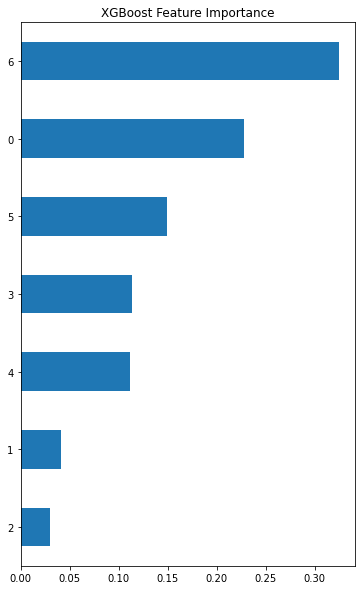

In [ ]:
mapFeat = dict(zip(["f"+str(i) for i in range(len(features))],features))
ts = pd.Series(clf.feature_importances_)
ts.sort_values()[-15:].plot(kind="barh", title=("features importance"))
plt.clf()

featp = ts.sort_values()[-15:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
fig_featp = featp.get_figure()
fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)
y_predtime = clf.predict(sel_test, ntree_limit=clf.best_iteration)
y_pred = clf.predict(X_test_s, ntree_limit=clf.best_iteration)
print(accuracy_score(y_test,y_pred))
print(accuracy_score(y_timetest,y_predtime))

In [ ]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [ ]:
confusion_matrix(y_test, y_pred)
confusion_matrix(y_timetest, y_predtime)

array([[205582,   2450],
       [ 30931,   9157]])

In [ ]:
params = xgb_bo.max['params']
print(params)
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])
params['scale_pos_weight'] = int(params['scale_pos_weight'])
params['tree_method'] = 'gpu_hist'
dtrain = xgb.DMatrix(X_train,label=y_train)
classifier = xgb.XGBClassifier(**params,n_jobs=8).fit(X_train,y_train)

{'colsamplebytree': 0.2361048384102603, 'gamma': 0.5121751008508277, 'learning_rate': 0.2465000605194717, 'max_delta_step': 0.39983571882473234, 'max_depth': 3.0897733091, 'n_estimators': 998.8780121549813, 'reg_alpha': 0.18212325581766198, 'scale_pos_weight': 13.74793175404568}


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
classifier = xgb.XGBClassifier(objective='binary:logistic',tree_method='gpu_hist')
classifier.fit(X_train[features].fillna(-999999),y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [ ]:
gc.collect()

39414

In [ ]:
X_train= X_train[features]
X_test = X_test[features]
timetest = timetest[features]

In [ ]:
classifier = xgb.XGBClassifier(objective='binary:logistic',tree_method='gpu_hist')
classifier.fit(X_train,y_train)
joblib.dump(classifier, '/content/drive/My Drive/Lending-Club/Models/XGB_M.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=3, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, tree_method='gpu_hist',
              verbosity=1)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
pd.DataFrame(dict(zip(X_train.columns,clasr.feature_importances_)).items()).to_excel('RFECV_Multi_best.xlsx')

In [ ]:
dfg[dfg[1]>0]

,0,1
0,int_rate,0.083718
1,installment,0.009766
2,annual_inc,0.008820
3,dti,0.013191
4,delinq_2yrs,0.003497
...,...,...
88,verification_status_Source Verified,0.005764
89,verification_status_Verified,0.005071
90,pymnt_plan_n,0.010079
92,initial_list_status_f,0.030094


In [ ]:
pd.DataFrame(dict(zip(X_train.columns,classifier.feature_importances_)).items()).to_excel('Best_bayesian_feature0vr.xlsx')

In [ ]:
y_predtrain = classifier.predict(X_train)
y_pred = classifier.predict(X_test)
y_predtime = classifier.predict(timetest)
print(classification_report(y_train, y_predtrain))
print(classification_report(y_test, y_pred))  
print(classification_report(y_timetest, y_predtime))

AttributeError: ignored

In [ ]:
dict(zip(X_train.columns,classifier.feature_importances_))

{'acc_now_delinq': 0.0030710706,
 'acc_open_past_24mths': 0.01006104,
 'all_util': 0.0048649083,
 'annual_inc': 0.007368912,
 'application_type_Individual': 0.017056458,
 'application_type_Joint App': 0.0,
 'avg_cur_bal': 0.008218673,
 'bc_open_to_buy': 0.006305657,
 'bc_util': 0.006219077,
 'chargeoff_within_12_mths': 0.0049847187,
 'collections_12_mths_ex_med': 0.0043600216,
 'delinq_2yrs': 0.004402531,
 'delinq_amnt': 0.0031158822,
 'dti': 0.0070116273,
 'earliest_cr_line': 0.0,
 'emp_length_1 year': 0.004451475,
 'emp_length_10+ years': 0.007085208,
 'emp_length_2 years': 0.0044371956,
 'emp_length_3 years': 0.004845163,
 'emp_length_4 years': 0.0041406816,
 'emp_length_5 years': 0.0041275783,
 'emp_length_6 years': 0.0047916095,
 'emp_length_7 years': 0.0052743005,
 'emp_length_8 years': 0.004399509,
 'emp_length_9 years': 0.004264127,
 'emp_length_less 1 year': 0.0048198164,
 'grade_A': 0.306375,
 'grade_B': 0.008867068,
 'grade_C': 0.008985515,
 'grade_D': 0.0046786014,
 'grade_

In [ ]:
fscores = pd.DataFrame({'X': list(classifier.get_fscore().keys()), 'Y': list(classifier.get_fscore().values())})
fscores.sort_values(by='Y').plot.bar(x='X')

AttributeError: ignored

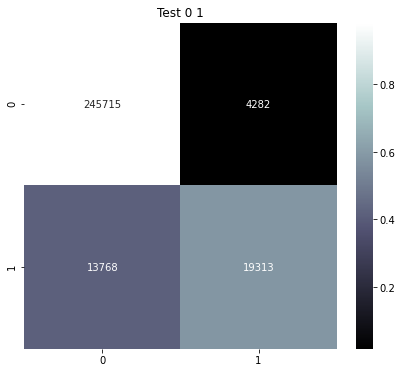

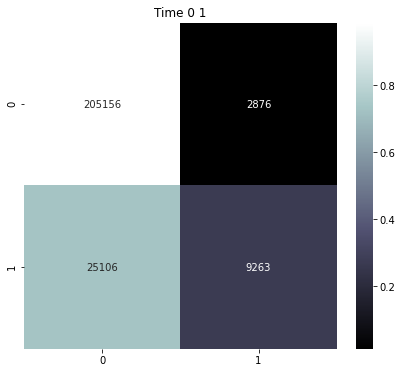

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    259483
         1.0       0.58      0.82      0.68     23595

    accuracy                           0.94    283078
   macro avg       0.78      0.88      0.82    283078
weighted avg       0.95      0.94      0.94    283078

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94    230262
         1.0       0.27      0.76      0.40     12139

    accuracy                           0.88    242401
   macro avg       0.63      0.83      0.67    242401
weighted avg       0.95      0.88      0.91    242401



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred=classifier.predict(X_test)
y_predtime=classifier.predict(timetest)
cm2 = confusion_matrix(y_test, y_pred)
cm3 = confusion_matrix(y_timetest, y_predtime)
def plot_confusion_matrix(cm, classes,title, normalized=True, cmap='bone'):
    plt.figure(figsize=[7, 6])
    norm_cm = cm
    plt.title(title)
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)
plot_confusion_matrix(cm2, ['0', '1'],'Test 0 1')
plot_confusion_matrix(cm3, ['0', '1'],'Time 0 1')
plt.show()
print('Test')
print(classification_report(y_pred, y_test))
print('Time')
print(classification_report(y_predtime,y_timetest))

In [ ]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 2.7MB/s 


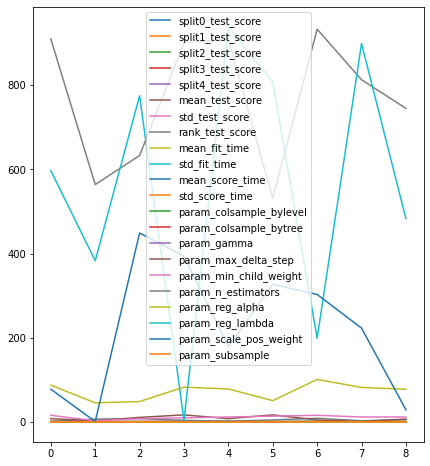

In [ ]:
pd.DataFrame(result.cv_results_).plot(figsize=(7,8))

In [ ]:
y_timepred

array([[0.46531236, 0.53468764],
       [0.998234  , 0.00176602],
       [0.65578496, 0.34421504],
       ...,
       [0.8783955 , 0.12160451],
       [0.8317586 , 0.16824137],
       [0.6388681 , 0.36113188]], dtype=float32)

In [ ]:
y_timepred=result.predict(timetest)
fp_rate, tp_rate, thresholds = roc_curve(y_timepred, y_timetest)
gini = 2*auc(fp_rate, tp_rate)-1
print(gini)

nan


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [ ]:
params = {'colsample_bylevel': 0.684890708829741, 'colsample_bytree': 0.6858047953450256, 'gamma': 0.027680960381780695, 'max_delta_step': 13, 'max_depth': 6, 'min_child_weight': 10, 'reg_alpha': 0.01923380793882639, 'reg_lambda': 8, 'scale_pos_weight': 362, 'subsample': 0.7691732515803242}

In [ ]:
xgb.XGBClassifier(**params,n_estimators=)

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])